# ONC API 2.0 Usage
Python API usage

[`https://wiki.oceannetworks.ca/display/O2A/Python+Client+Library`](https://wiki.oceannetworks.ca/display/O2A/Python+Client+Library)

Timeseries parameters

[`https://wiki.oceannetworks.ca/display/DP/1`](https://wiki.oceannetworks.ca/display/DP/1)

ADCP parameters

[`https://wiki.oceannetworks.ca/display/DP/5`](https://wiki.oceannetworks.ca/display/DP/5)

***

### Installation

`$ pip install onc`

***

### Import libraries

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import warnings
from datetime import datetime, timedelta
from dateutil.parser import parse
from cmocean import cm
from mpl_toolkits.basemap import Basemap

# ONC library
from onc.onc import ONC

%matplotlib inline
plt.rcParams['font.size'] = 12
warnings.simplefilter('ignore')

***

## Basic usage

Invoke ONC using token

In [3]:
onc = ONC(
    token='76fc91e5-d4a4-40f9-87fc-2f6d2707fc5a',
    outPath='/ocean/bmoorema/research/MEOPAR/analysis-ben/data/ONC',
)

***

### Browsing data and locations

**`onc.getLocations()`**

In [4]:
# Print all locations with ADCP150KHZ data
for location in onc.getLocations({'deviceCategoryCode': 'ADCP150KHZ'}):
    print(f"{location['locationCode']:10s}", location['locationName'])

BACME      MidEast
BACMW      MidWest
RVSKQ      R/V Sikuliaq
SCVIP      Strait of Georgia VENUS Instrument Platform
SEVIP      Strait of Georgia East VENUS Instrument Platform
VEC        CCGS Vector


**`onc.getDeviceCategories()`**

In [5]:
# Print all devices at ONC Central Node
for device in onc.getDeviceCategories({'locationCode': 'SCVIP'}):
    print(f"{device['deviceCategoryCode']:20s}", device['description'])

ADCP150KHZ           150 kHz Acoustic Doppler Current Profiler
ADCP600KHZ           600 kHz Acoustic Doppler Current Profiler
CTD                  Conductivity Temperature (and Depth Sensor)
CURRENTMETER         Current Meter
ECHOSOUNDERBIOA      Bioacoustic single beam echosounder
FLNTU                Combined Fluorometer and Turbidity Sensor
HYDROPHONE           Hydrophone
JB                   Junction Box
OXYSENSOR            Oxygen Sensor
PARTANALYZER         Particle Size Distribution Analyzer
TURBIDITYMETER       Turbidity Meter
VIDEOCAM             Video Camera


**`onc.getDataProducts()`**

In [6]:
# Print all data products at ONC Central Node
for dataproduct in onc.getDataProducts({'locationCode': 'SCVIP', 'extension': 'nc'}):
    print(f"{dataproduct['dataProductCode']:10s}", dataproduct['dataProductName'])

CSPPD      Cast Scalar Profile Plot and Data
RADCPTS    RDI ADCP Time Series
TSSD       Time Series Scalar Data
TSSPPGD    Time Series Scalar Profile Plot and Gridded Data


**`onc.getListByLocation()`**

In [7]:
# Print all CTD and ADCP files available at ONC Central Node in a given range
filters = {'dateFrom': '2019-01-01T00:00:00.000Z', 'dateTo': '2019-01-05T00:00:00.000Z'}
for device in ['CTD', 'ADCP150KHZ']:
    for filename in onc.getListByLocation(locationCode='SCVIP', deviceCategoryCode=device, filters=filters)['files']:
        print(filename)

SBECTD19p6937_20190101T000000.000Z.txt
SBECTD19p6937_20190102T000000.000Z.txt
SBECTD19p6937_20190103T000000.000Z.txt
SBECTD19p6937_20190104T000000.000Z.txt
RDIADCP150WH8580_20190101T000000.000Z.txt
RDIADCP150WH8580_20190102T000000.000Z.txt
RDIADCP150WH8580_20190103T000000.000Z.txt
RDIADCP150WH8580_20190104T000000.000Z.txt


***

### Previewing data

**`onc.getDirectScalar()`**

In [8]:
# Basic filters for 24 hours of Central Node CTD data
filters = {
    'locationCode': 'SCVIP',
    'deviceCategoryCode': 'CTD',
    'dateFrom': '2019-01-01T00:00:00.000Z',
    'dateTo': '2019-01-02T00:00:00.000Z',
}

# Load data from ONC repo into JSON format
# -- max I was able to get is about 1 day of scalar data
# -- doesn't seem to be available for ADCP profile data
data = onc.getDirectScalar(filters)

In [9]:
# List available sensors and store their list indices
isensor = {}
for i, sensor in enumerate(data['sensorData']):
    isensor[sensor['sensorName']] = i
    print(f"{i:<3d}{sensor['sensorName']:25s}", sensor['unitOfMeasure'])

0  Pressure                  decibar
1  Sigma-theta (0 dbar)      kg/m3
2  Sound Speed               m/s
3  Temperature               C
4  Conductivity              S/m
5  Density                   kg/m3
6  Depth                     m
7  Practical Salinity        psu
8  Sigma-t                   kg/m3


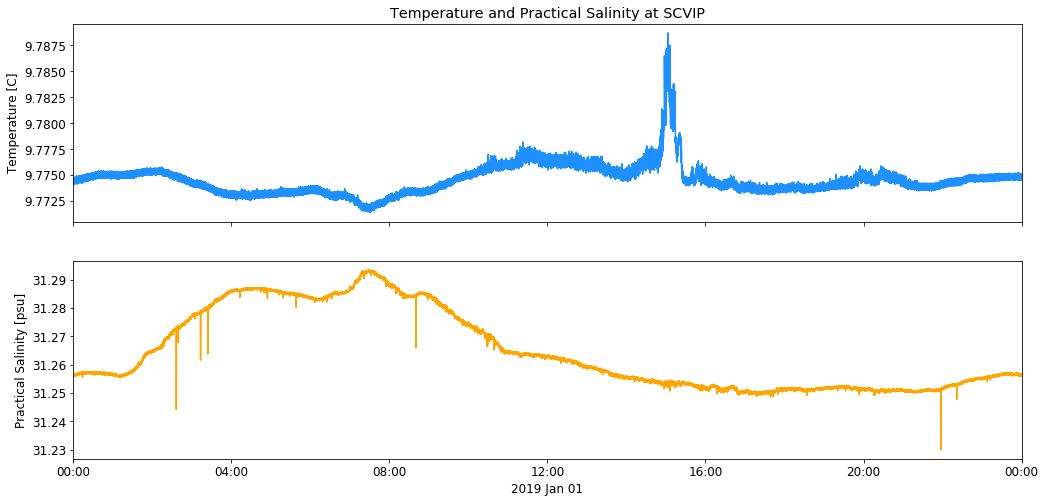

In [10]:
# -- Plot temperature and salinity data --
keys = ['Temperature', 'Practical Salinity']
fig, axs = plt.subplots(2, 1, figsize=(17, 8))
axs[0].set_title(' and '.join(keys) + ' at ' + filters['locationCode'])
axs[0].xaxis.set_ticklabels('')
axs[1].set_xlabel(parse(filters['dateFrom']).strftime('%Y %b %d'))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
for ax, key, color in zip(axs, keys, ['dodgerblue', 'orange']):
    ax.plot(
        [parse(t) for t in data['sensorData'][isensor[key]]['data']['sampleTimes']],
        data['sensorData'][isensor[key]]['data']['values'], color=color,
    )
    ax.set_xlim([parse(filters[key]) for key in ['dateFrom', 'dateTo']])
    ax.set_ylabel(f"{key} [{data['sensorData'][isensor[key]]['unitOfMeasure']}]")
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))

***

### Downloading data

**`onc.orderDataProduct()`**

ADCP example. Filters will be different for e.g., CTD.

In [11]:
# Filters for ONC Central Node ADCP data
# dpo parameters from https://wiki.oceannetworks.ca/display/DP/5
filters = {
    'locationCode': 'SCVIP',
    'deviceCategoryCode': 'ADCP150KHZ',
    'dataProductCode': 'RADCPTS',
    'extension': 'nc',
    'dateFrom': '2019-01-01T00:00:00.000Z',
    'dateTo': '2019-01-02T00:00:00.000Z',
    'dpo_ensemblePeriod': 900,    # Default value
    'dpo_velocityBinmapping': 2,  # Default value
    'dpo_3beam': 'Off',           # Default value
    'dpo_corScreen': 64,          # Default value
    'dpo_errVelScreen': 2,        # Default value
    'dpo_falseTarScreen': 255,    # Default value
}

# Download data
# -- may time out if maxRetries is too low
downloadDetails = onc.orderDataProduct(filters=filters, maxRetries=100, includeMetadataFile=False)

Request Id: 3126643
Estimated File Size: No estimated file size available.
  Running.
  Running... working on time range 1 of 1, for device deployment 1 of 1.................................................
  Skipping 1 'Central_StraitofGeorgiaVENUSInstrumentPlatform_ADCP150kHz_20190101T000000Z_20190102T000000Z-Ensemble900s_binMapLinearInterp.nc': File Already Exists
  1 files (72.1 KB) downloaded
Actual Processing/Download Time: 0:1:49.62


In [12]:
# List download parameters
for item in downloadDetails['downloadResults'][0].items():
    print(item[0] + ':', item[1])

url: http://data.oceannetworks.ca/api/dataProductDelivery?method=download&token=76fc91e5-d4a4-40f9-87fc-2f6d2707fc5a&dpRunId=8219941&index=1
message: ['Running', 'Running... working on time range 1 of 1, for device deployment 1 of 1.']
queuingTime: 0
runningTime: 106.740811
transferringTime: 0
downloadingTime: 0.094302
requestCount: 52
status: complete
size: 73828.0
file: /ocean/bmoorema/research/MEOPAR/analysis-ben/data/ONC/Central_StraitofGeorgiaVENUSInstrumentPlatform_ADCP150kHz_20190101T000000Z_20190102T000000Z-Ensemble900s_binMapLinearInterp.nc
index: 1
downloaded: True


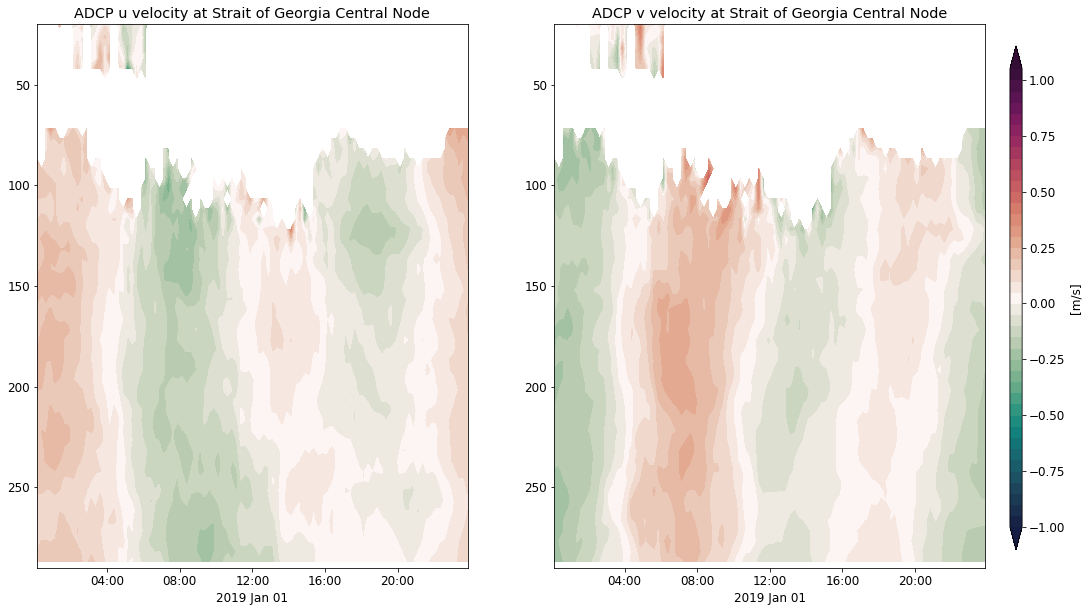

In [17]:
# -- Load and plot ADCP velocities --
data = xr.open_dataset(downloadDetails['downloadResults'][0]['file'])
date = data.time.values.astype('datetime64[s]').astype(datetime)
fig, axs = plt.subplots(1, 2, figsize=(17, 10))
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
for ax, vel in zip(axs, ['u', 'v']):
    c = ax.contourf(date, data.depth, data[vel].T, levels=np.arange(-1, 1.1, 0.05), cmap=cm.curl, extend='both')
    ax.set_ylim([290, 20])
    ax.set_title(f'ADCP {vel} velocity at {data.location_name}')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
    ax.set_xlabel(parse(filters['dateFrom']).strftime('%Y %b %d'))
fig.colorbar(c, cax=cax, label='[m/s]')
plt.show()

***

## Some Browsing Examples

Here I look for locations with device categories that I'm interested in, and plot them on a map. This first function plots a map of the Salish Sea using Basemap

In [12]:
def plot_map(ax, lons, lats):
    """Plot a map of the Salish Sea ONC region given lons and lats as bounds
    """

    # Make projection
    m = Basemap(
        ax=ax, projection='lcc', resolution='h',
        lon_0=(int(np.diff(lons))) / 2 + lons[0],
        lat_0=(int(np.diff(lats))) / 2 + lats[0],
        llcrnrlon=lons[0], urcrnrlon=lons[1],
        llcrnrlat=lats[0], urcrnrlat=lats[1],
    )
    
    # Add features and labels
    m.drawcoastlines()
    m.fillcontinents(color='Burlywood')
    m.drawmeridians(np.arange(*np.floor([lons[0], lons[1] + 1])), labels=[0, 0, 0, 1], color='k')
    m.drawparallels(np.arange(*np.floor([lats[0], lats[1] + 1])), labels=[1, 0, 0, 0], color='k')
    m.drawrivers()
    
    return m

This next function calls the map function and overlays the device locations using: `onc.getLocations()`

In [13]:
def plot_device_locations(devicelist):
    """Plot locations of two lists of specified devices on a map
    """

    # Make figure
    fig, axs = plt.subplots(1, 2, figsize=(17, 10))
    ms = [plot_map(ax, [-126, -122], [48, 51]) for ax in axs]

    # Loop through devices
    for ax, m, devices in zip(axs, ms, devicelist):
        for device, color in zip(devices, ['c', 'r', 'y', 'green', 'm', 'k']):
            label = device
            if device is 'RADCPTS':  # Use dataProductCode for ADCP (multiple frequencies)
                key = 'dataProductCode'
            else:
                key = 'deviceCategoryCode'

            # Identify and plot device locations
            for location in onc.getLocations({key: device}):  # Main ONC function call
                if (location['lon'] is not None) and (location['lat'] is not None):
                    ax.plot(
                        *m(location['lon'], location['lat']),
                        'ko', markerfacecolor=color, markersize=8, label=label,
                    )
                    label = None

        # Legend
        ax.legend()
    
    return fig, axs, ms

### Locations with physical data devices

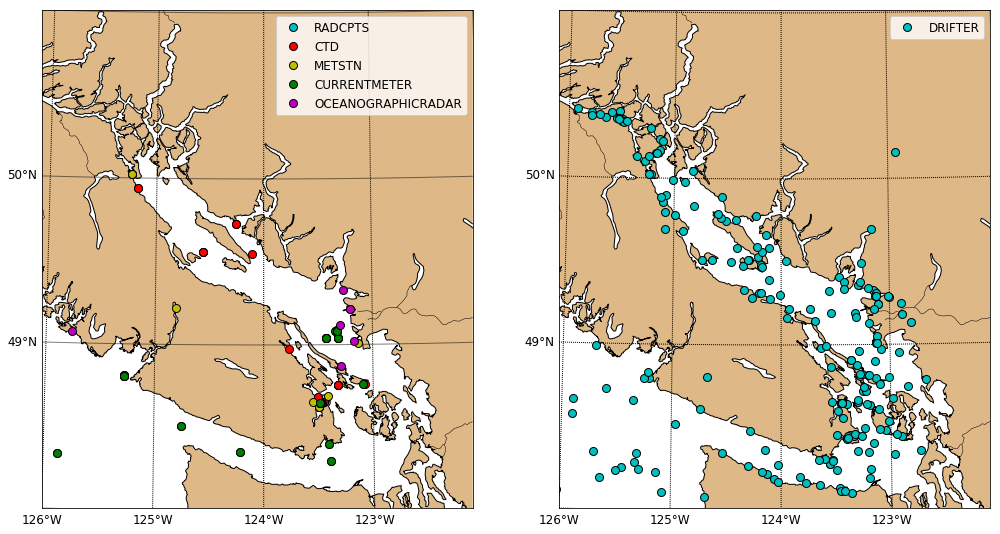

In [14]:
# Plot locations of physical data devices
devicelist = [
    ['RADCPTS', 'CTD', 'METSTN', 'CURRENTMETER', 'OCEANOGRAPHICRADAR'],
    ['DRIFTER'],
]
fig, axs, ms = plot_device_locations(devicelist)

### Locations with biological and chemical data devices

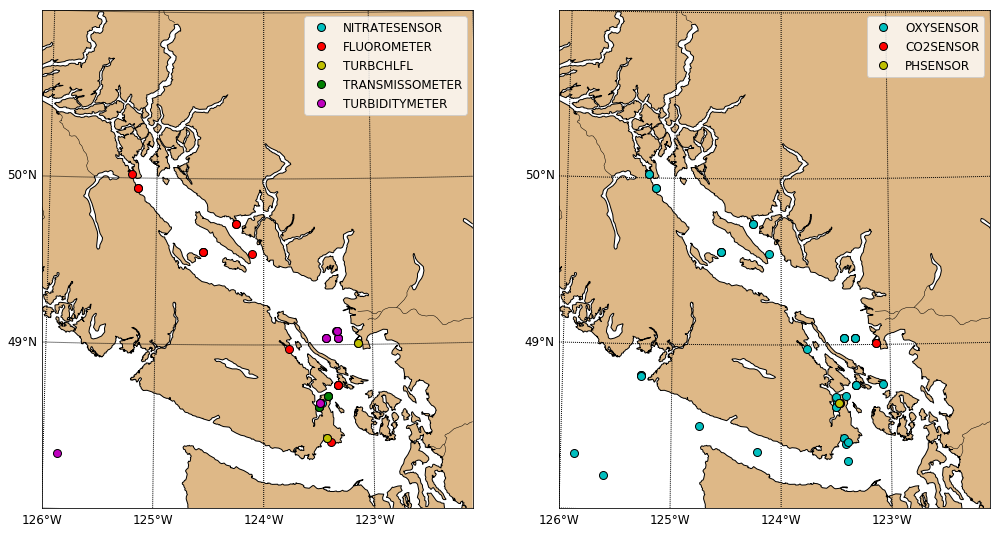

In [15]:
# Plot locations of biological and chemical data devices
devicelist = [
    ['NITRATESENSOR', 'FLUOROMETER', 'TURBCHLFL', 'TRANSMISSOMETER', 'TURBIDITYMETER'],
    ['OXYSENSOR', 'CO2SENSOR', 'PHSENSOR'],
]
fig, axs, ms = plot_device_locations(devicelist)